In [341]:
# Import necessary libraries
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import SeqIO, Phylo, Entrez
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Align import AlignInfo
from Bio.Align import AlignInfo, MultipleSeqAlignment
from Bio.Align import PairwiseAligner
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from logomaker import Logo
from logomaker import alignment_to_matrix


## 1. Importing the Necessary Libraries

**From BioPython:**
- Bio.Blast: used to submit sequences to NCBI databases and search for homologues across species 
- Bio.SeqIO: used for parsing sequences from input files for alignment and writing alignments to output files in FASTA format
- Bio.Phylo: used for drawing Phylogenetic trees (Phylo.draw function) and (Bio.Phylo.TreeConstruction)
- Bio.Align: used for multiple and pairwise alignment of seqences, and (Align.Info) tool is used for extracting positon-specific scoring matricies (PSSM scores)
- Bio.SeqRecord: adds metadata such as descriptions and IDs to sequences
- Bio.Entrez: Connects to NCBI's Entrez database to retreieve sequence and domain data

**From matplotlib:**
- pyplot.figure: used to customize figure labels, size and layout

**From numpy:**
- np.array: used to covert data to a format which can be used in plots

**From collections:**
- Counter: used to summarize the amino acid composition across the alignment and count the frequency of amino acids in the alignmed sequences

**From Logomaker:**
- alignment_to_matrix: converts the alignment to a frequency matrix 
- Logo: used to convert the frequency matrix to generate a sequence logo



In [344]:
# Performing a BLAST search to search for homoglogues
def perform_blast(query_file, output_file):
    print("Running BLAST...")
    with open(query_file) as f:
        blast_results = NCBIWWW.qblast("blastp", "nr", f.read())
    
    with open(output_file, "w") as out_file:
        out_file.write(blast_results.read())
    print(f"BLAST results saved to {output_file}")


## 2. Define Functions for Sequence Analysis

**Aim:** Search NCBI protein database for homogogous sequences to our queries

*perform_blast(query_file, output_file)*
- uses query in FASTA format
- performs BLAST search for homologues using (qblast)
- saves BLAST results in an XML file.


In [347]:
# Parse BLAST results and save homologs in FASTA format
def parse_blast_results(blast_file, fasta_output, e_value_threshold=1e-5):
    print("Parsing BLAST results...")
    with open(blast_file) as result_handle:
        blast_records = NCBIXML.parse(result_handle)
        with open(fasta_output, "w") as output_handle:
            for blast_record in blast_records:
                for alignment in blast_record.alignments:
                    for hsp in alignment.hsps:
                        if hsp.expect < e_value_threshold:
                            output_handle.write(f">{alignment.title}\n")
                            output_handle.write(f"{hsp.sbjct}\n")
    print(f"Homologous sequences saved to {fasta_output}")

**Aim:** to filter and save relavent homologues for further analysis 

*parse_blast_results(blast_file, fasta_output, e_value_threshold=1e-5)*
- Used to parse the BLAST XML results file
- Extrat the sequences with an e-value below the specified threshold (used 1e-5)
- Saves the homologous sequences to a FASTA file 

In [350]:
# Retrieve additional homologous sequences
def retrieve_homologs(query_file, homologs_file):
    print("Retrieving homologous sequences...")
    Entrez.email = "helenerittscher@gmail.com"  # Replace with your email
    with open(query_file) as f:
        for record in SeqIO.parse(f, "fasta"):
            query_id = record.id
            print(f"Searching homologs for: {query_id}")
            handle = Entrez.esearch(db="protein", term=query_id, retmax=10)
            record_ids = Entrez.read(handle)['IdList']
            with open(homologs_file, "w") as output_handle:
                for prot_id in record_ids:
                    prot_handle = Entrez.efetch(db="protein", id=prot_id, rettype="fasta", retmode="text")
                    output_handle.write(prot_handle.read())
    print(f"Homologous sequences saved to {homologs_file}")

**Aim:** To retrieve homologous protein sequences from Entrez. 
(This does not rely on BLAST so by querying this database it broadens the scope of the search and may reduce database biases as well as improve reproducability.)

*retrieve_homologs(query_file, homologs_file)*
- Uses Entrez API to seach for homologous sequences
- Retrieves homologous sequences in FASTA format and saves them 

In [353]:
# Function to pad sequences to the same length
def pad_sequences(sequences):
    print("Padding sequences to the same length...")
    max_length = max(len(seq.seq) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        padded_seq = SeqRecord(Seq(str(seq.seq).ljust(max_length, "-")), id=seq.id, description=seq.description)
        padded_sequences.append(padded_seq)
    return padded_sequences

**Aim:** To ensure all sequences are aligned to the same length, so they can be used in the alignment tools in later steps

*pad_sequences(sequences)*
- Pads all sequences to the same length by appending gaps (-) where needed
- returns a list of padded sequences

In [356]:
# Performing sequence alignment using Biopython PairwiseAligner
def align_sequences(input_file, output_file):
    print("Aligning sequences using Biopython PairwiseAligner...")
    aligner = PairwiseAligner()
    aligner.mode = "global"  # Use global alignment

    sequences = list(SeqIO.parse(input_file, "fasta"))
    if len(sequences) < 2:
        print("Error: At least two sequences are required for alignment.")
        return

    padded_sequences = pad_sequences(sequences)
    msa = MultipleSeqAlignment(padded_sequences)

    with open(output_file, "w") as output_handle:
        SeqIO.write(msa, output_handle, "fasta")

    print(f"Alignment saved to {output_file}")

**Aim:** To align sequences for phylogenetic and analysis of motifs

*align_sequences(input_file, output_file)*

- PairwiseAligner from Biopythin used for gloal alignmal on sequences from the FASTA input file
- pads sequences to the same length before alignment
- aligned sequences are saved to an output FASTA file


In [359]:
# Building and visualizing a phylogenetic tree with better spacing
def build_phylogenetic_tree(alignment_file, tree_output):
    print("Building phylogenetic tree...")
    alignment = MultipleSeqAlignment(SeqIO.parse(alignment_file, "fasta"))

    # Calculate the distance matrix
    calculator = DistanceCalculator("identity")
    distance_matrix = calculator.get_distance(alignment)

    # Construct the phylogenetic tree
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(distance_matrix)

    # Save the tree in Newick format
    Phylo.write(tree, tree_output, "newick")
    print(f"Phylogenetic tree saved to {tree_output}")

    # Visualize the tree with advanced layout adjustments
    fig = plt.figure(figsize=(16, 12))  # Larger figure size for clarity
    ax = fig.add_subplot(1, 1, 1)
    Phylo.draw(tree, axes=ax, do_show=False)

    # Customizing the Phylogenetic Tree Figure
    plt.title("Phylogenetic Tree", fontsize=16)
    plt.xlabel("Branch Length", fontsize=12)
    plt.ylabel("Taxa", fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()

**Aim:** Build a phylogenetic tree to analyze the evolutionary relationships between homologous sequences

*build_phylogenetic_tree(alignment_file, tree_output)*
- Calculates a distance matrix from the aigned sequences
- Uses the neighbor-joining mehod to contruct a phylogenetic tree
- Tree saved in Newick format and made into a customizable figure using Matplotlib

In [362]:
# Function to analyze conserved domains using Entrez
# Requires valid Entrez email registration
def analyze_conserved_domains(fasta_file):
    print("Analyzing conserved domains...")
    Entrez.email = "helenerittscher@gmail.com"  # Replace with your email
    with open(fasta_file) as f:
        for record in SeqIO.parse(f, "fasta"):
            print(f"Fetching domains for: {record.id}")
            handle = Entrez.efetch(db="protein", id=record.id, rettype="gp", retmode="text")
            print(handle.read())  # Modify to save or parse results


**Aim:** Identify conserved domains within the protein sequences

*analyze_conserved_domains(fasta_file)*
- Retrieves domain information for the protein sequences using Entrez API
- Prints domain data

In [376]:
# Visualizing motifs 
def visualize_motifs(alignment_file):
    print("Visualizing motifs...")
    alignment = list(SeqIO.parse(alignment_file, "fasta"))

    # Convert alignment into a position-specific scoring matrix (PSSM)
    msa = MultipleSeqAlignment(alignment)
    summary_align = AlignInfo.SummaryInfo(msa)
    pssm = summary_align.pos_specific_score_matrix()

    # Truncate PSSM to the first 230 positions
    truncated_data = np.array([list(column.values())[:230] for column in pssm]).T

    # Visualize truncated PSSM as a heatmap
    plt.figure(figsize=(14, 8))  # Adjust figure size for clarity
    plt.imshow(truncated_data, aspect="auto", cmap="viridis")
    plt.colorbar(label="Score")
    plt.title("Motif Visualization (PSSM Heatmap)")
    plt.xlabel("Position in Alignment")
    plt.ylabel("Amino Acids")
    plt.xlim((0,230))
    plt.tight_layout()
    plt.show()

**Aim:** To identify and visualize the conserved motifs in the protein sequences

*visualize_motifs(alignment_file)*
- Uses the alignment to extract a position-specific scoring matrix (PSSM)
- A heatmap os the PSSM is created for the first 230 residues as sequences do not exceed this length
- This figure helps to visualize conserved motifs in the aligned sequences

In [389]:
# Calculating amino acid frequencies
def compute_amino_acid_frequencies(alignment_file):
    print("Computing amino acid frequencies...")
    alignment = list(SeqIO.parse(alignment_file, "fasta"))
    concatenated_seqs = "".join([str(record.seq) for record in alignment])
    frequencies = Counter(concatenated_seqs)
    print("Amino acid frequencies:")
    for aa, freq in frequencies.items():
        print(f"{aa}: {freq}")
    return frequencies


**Aim:** Analyze the amino acd composion in the aligned sequences

*compute_amino_acid_frequencies(aligment_file)
- counts the frequency of each amino acid across all sequences in the alignment
- prints the frequencies for interpretation
  

In [382]:
# Visualizing the sequence motifs using a sequence logo ( 230 residues only)
def visualize_sequence_logo(alignment_file):
    print("Visualizing sequence motifs using sequence logo...")
    alignment = list(SeqIO.parse(alignment_file, "fasta"))

    # Convert alignment into a frequency matrix
    sequences = [str(record.seq)[:230] for record in alignment]  # Truncate to first 200 residues
    alignment_matrix = alignment_to_matrix(sequences)

    # Plot the sequence logo
    plt.figure(figsize=(14, 8))  # Wider figure size for better spacing
    logo = Logo(alignment_matrix, font_name='Arial', color_scheme='chemistry')
    logo.style_spines(visible=False)
    logo.ax.set_xticks(range(0, 231, 20))  # Add ticks every 20 residues
    logo.ax.set_xticklabels(range(1, 232, 20), fontsize=10)  # Adjust tick font size
    logo.ax.set_title("Sequence Logo", fontsize=16)
    logo.ax.set_xlabel("Residue Position", fontsize=12)
    logo.ax.set_ylabel("Information Content", fontsize=12)
    plt.tight_layout()
    plt.show()

**Aim:** Visualize the conserved sequence features 

*Visualize_sequence_logo(alignment_file)*
- converts the sequence akignment into a frequency matrix for 230 residues
- uses Logomaker to create a sequence logo visualization
- Adjusts axis labels and formatting 

Retrieving homologous sequences...
Searching homologs for: RABC2A
Searching homologs for: RABD1
Homologous sequences saved to homologs.fasta
Aligning sequences using Biopython PairwiseAligner...
Padding sequences to the same length...
Alignment saved to aligned_homologs.fasta
Building phylogenetic tree...
Phylogenetic tree saved to aligned_homologs.dnd


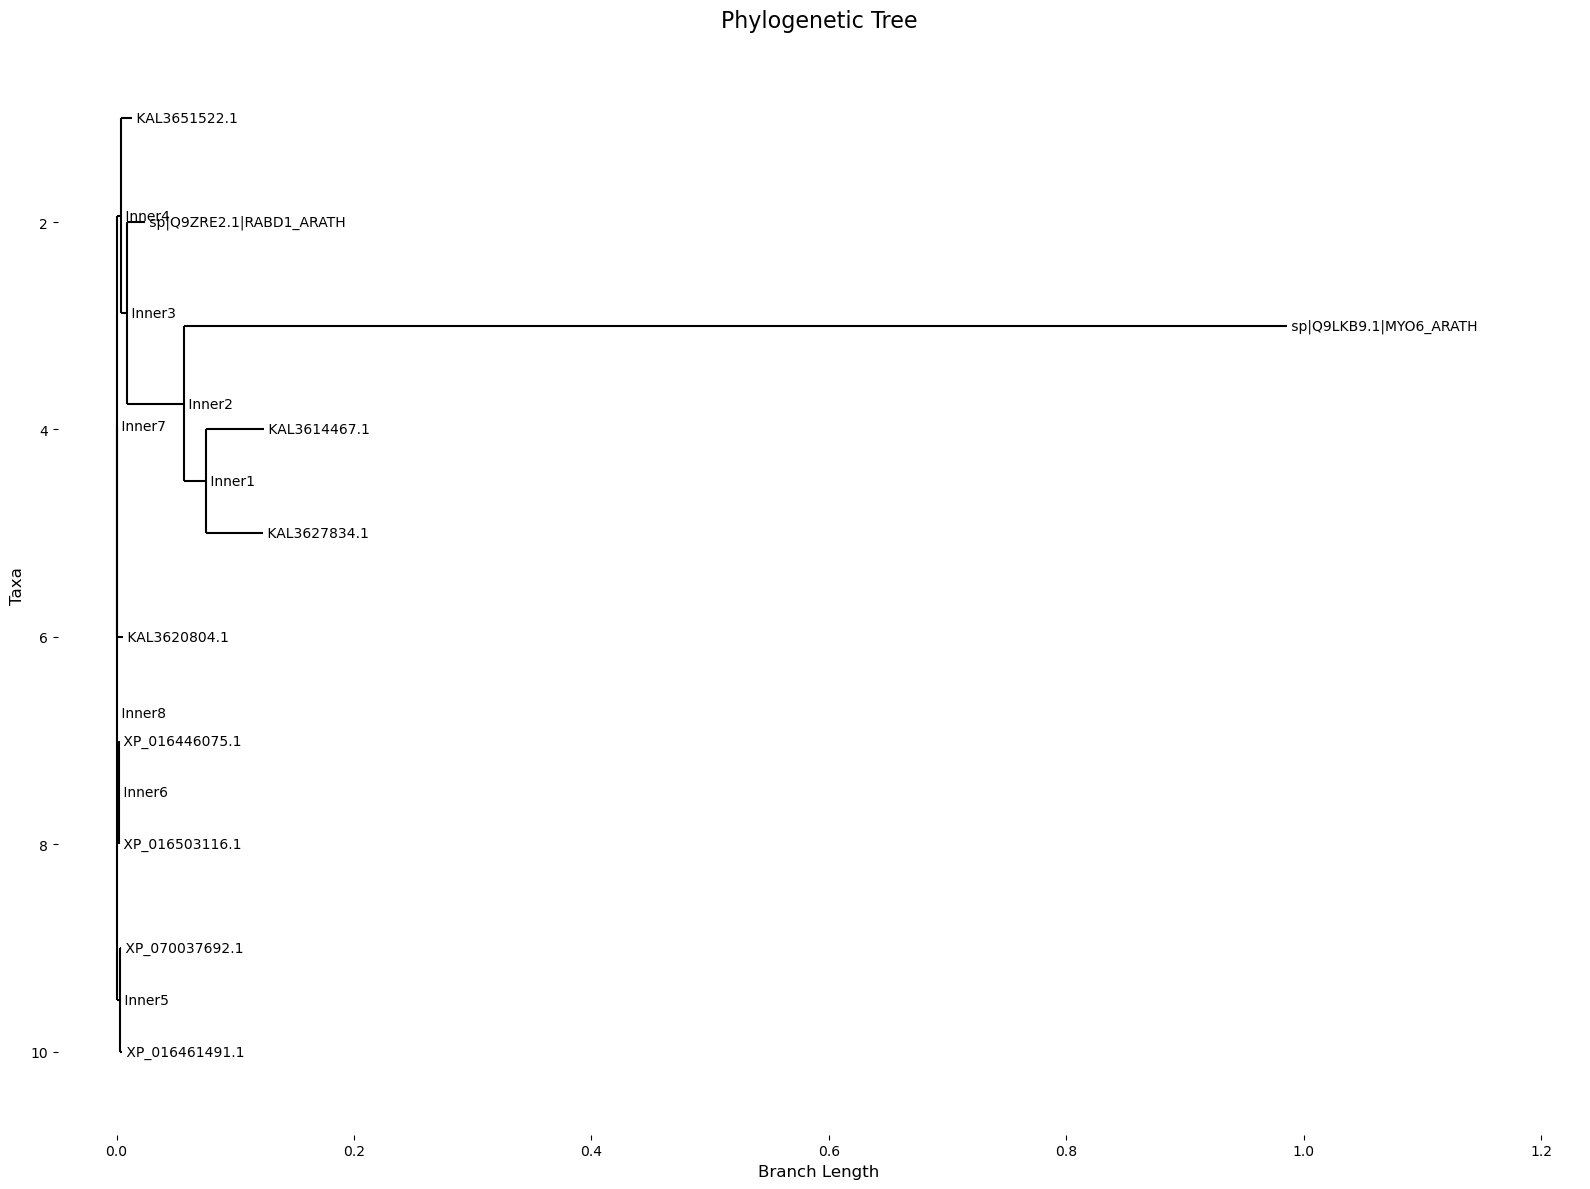

Analyzing conserved domains...
Fetching domains for: KAL3651522.1
LOCUS       KAL3651522               203 aa            linear   PLN 17-DEC-2024
DEFINITION  Ras-related protein rabd1 [Castilleja foliolosa].
ACCESSION   KAL3651522
VERSION     KAL3651522.1
DBLINK      BioProject: PRJNA1011274
            BioSample: SAMN37213163
DBSOURCE    accession JAVIJP010000006.1
KEYWORDS    .
SOURCE      Castilleja foliolosa
  ORGANISM  Castilleja foliolosa
            Eukaryota; Viridiplantae; Streptophyta; Embryophyta; Tracheophyta;
            Spermatophyta; Magnoliopsida; eudicotyledons; Gunneridae;
            Pentapetalae; asterids; lamiids; Lamiales; Orobanchaceae;
            Pedicularideae; Castillejinae; Castilleja.
REFERENCE   1  (residues 1 to 203)
  AUTHORS   Buerger,M., Peterson,D. and Chory,J.
  TITLE     Strigolactones Initiate the Formation of Haustorium-like Structures
            in Castilleja
  JOURNAL   iScience, 111491 (2024)
  REMARK    DOI: 10.1016/j.isci.2024.111491
REFEREN

/opt/anaconda3/lib/python3.12/site-packages/Bio/Align/AlignInfo.py:364: BiopythonDeprecationWarning: The `pos_specific_score_matrix` method is deprecated and will be removed in a future release of Biopython. As an alternative, you can convert the multiple sequence alignment object to a new-style Alignment object by via its `.alignment` property, and then create a Motif object. For example, for a multiple sequence alignment `msa` of DNA nucleotides, you would do: 
>>> alignment = msa.alignment
>>> from Bio.motifs import Motif
>>> motif = Motif('ACGT', alignment)
>>> counts = motif.counts

The `counts` object contains the same information as the PSSM returned by `pos_specific_score_matrix`, but note that the indices are reversed:

>>> counts[letter][i] == pssm[index][letter]
True

If your multiple sequence alignment object was obtained using Bio.AlignIO, then you can obtain a new-style Alignment object directly by using Bio.Align.read instead of Bio.AlignIO.read, or Bio.Align.parse inste

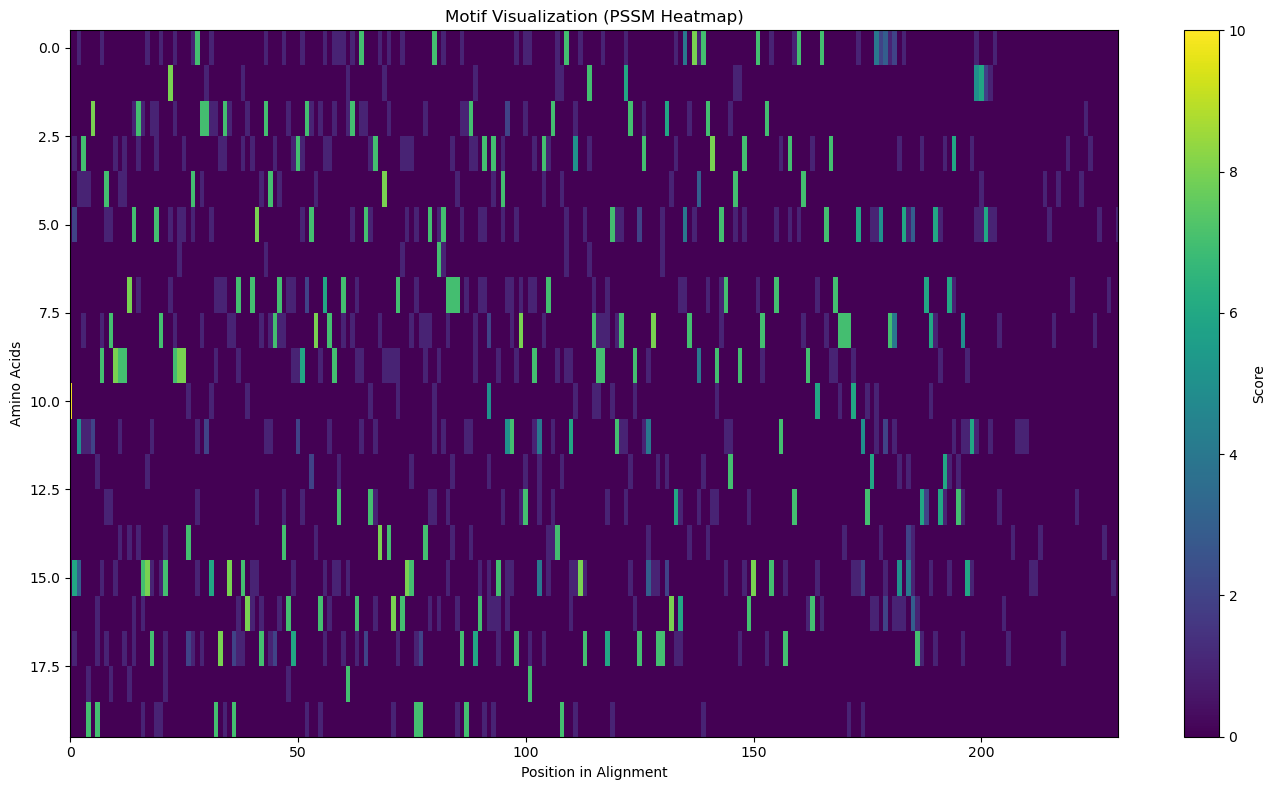

Visualizing sequence motifs using sequence logo...


<Figure size 1400x800 with 0 Axes>

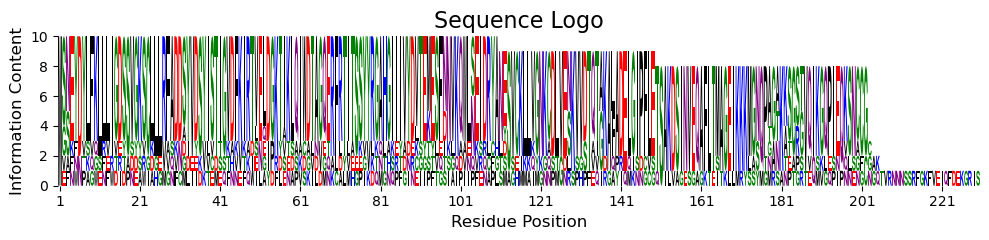

In [385]:
# Main script
def main():
    # Input query sequences for BLAST
    query_file = "query_sequence.fasta"  # Input query sequence in FASTA format

    # Define sequences for RABC2A and RABD1
    sequences = {
        "RABC2A": "MGSSSGQSGYDLSFKILLIGDSGVGKSSLLVSFISSSVEDLAPTIGVDFKIKQLTVGGKRLKLTIWDTAGQERFRTLTSSYYRGAQGIILVYDVTRRETFTNLVDVWGKEIELYSTNQECVRMLVGNKVDRESERGVSREEGIALAKELNCMFLECSARTRQNVEQCFEELALKIMEVPSLLEEGSSAVKRNILKQKPEHQTNTQSGCCS",
        "RABD1": "MSNEYDYLFKLLLIGDSSVGKSCLLLRFADDAYIDSYISTIGVDFKIRTIEQDGKTIKLQIWDTAGQERFRTITSSYYRGAHGIIIVYDCTEMESFNNVKQWLSEIDRYANESVCKLLIGNKNDMVESKVVSTETGRALADELGIPFLETSAKDSINVEQAFLTIAGEIKKKMGSQTNANKTSGPGTVQMKGQPIQQNNGGCCGQ"
    }

    # Write sequences to the query file
    with open(query_file, "w") as f:
        for name, seq in sequences.items():
            f.write(f">{name}\n{seq}\n")

    homologs_fasta = "homologs.fasta"  # Homologous sequences
    blast_output = "blast_results.xml"  # BLAST results (optional if using BLAST)
    aligned_file = "aligned_homologs.fasta"  # Aligned sequences
    tree_file = "aligned_homologs.dnd"  # Phylogenetic tree

    # Step 1: Retrieve homologous sequences
    retrieve_homologs(query_file, homologs_fasta)

    # Step 2: Align sequences
    align_sequences(homologs_fasta, aligned_file)

    # Step 3: Build and visualize a phylogenetic tree
    build_phylogenetic_tree(aligned_file, tree_file)

    # Step 4: Analyze conserved domains
    analyze_conserved_domains(homologs_fasta)

    # Step 5: Visualize motifs as heatmap
    visualize_motifs(aligned_file)

    # Step 6: Visualize motifs as sequence logo
    visualize_sequence_logo(aligned_file)

if __name__ == "__main__":
    main()

## 3.Executing the Main Script 

**Aim:** Execute the pipeline where all functions have been saved to *main()*

**Overview of Final Pipeline**
1. **Query Sequence Input:**
   - Protein coding query sequences (**RABC2A** and **RABD1**) defined and saved in FASTA format (these can be replaced with any query sequences)
2. **Retreieve Homologous Sequences**
   - Using the ***align_sequences()*** function
3. **Sequence Alignment**
   - Homologous sequences were aligned using the ***align_sequences()*** function
4. **Constructing a Phylogenetic Tree**
   - Visualize the genetic similarity between queries and homologues using the ***build_phylogenetic_tree()*** function
5. **Conserved domain analysis**
   - Using the ***analyze_conserved_domains()*** function
6. **Visualize Motifs**
   - Motifs visualized through a PSSM heatmap using the ***visualize_motifs()*** function
7. **Sequence Logo**
   - Sequence Logo created to display the conserved features using the ***visualize_sequence_logo()*** function 